## Classifying the cifar10 dataset using pytorch

First we have to import all the libraries we will be using in this example.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import random_split, DataLoader, TensorDataset
import jovian

%matplotlib inline

In [2]:
batch_size = 128

num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
train_ds = torchvision.datasets.CIFAR10(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="data/", train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [4]:
len(train_ds), len(test_ds)

(50000, 10000)

In [5]:
def imshow(img):    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

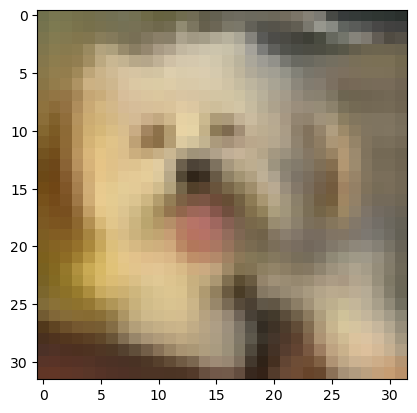

tensor([[[0.4392, 0.4745, 0.4706,  ..., 0.1843, 0.1765, 0.1647],
         [0.4588, 0.4902, 0.4902,  ..., 0.2824, 0.2588, 0.2510],
         [0.4824, 0.5137, 0.5137,  ..., 0.3843, 0.3137, 0.3333],
         ...,
         [0.2980, 0.3137, 0.3059,  ..., 0.8314, 0.7765, 0.6902],
         [0.3451, 0.3490, 0.3373,  ..., 0.8039, 0.7882, 0.7098],
         [0.3804, 0.3843, 0.3725,  ..., 0.7647, 0.7765, 0.7294]],

        [[0.4431, 0.4667, 0.4588,  ..., 0.2118, 0.2039, 0.1882],
         [0.4510, 0.4784, 0.4706,  ..., 0.2784, 0.2549, 0.2510],
         [0.4588, 0.4824, 0.4745,  ..., 0.3608, 0.2941, 0.3137],
         ...,
         [0.1922, 0.1961, 0.1882,  ..., 0.7255, 0.6902, 0.6235],
         [0.2039, 0.2000, 0.1961,  ..., 0.6784, 0.6510, 0.5843],
         [0.2118, 0.2118, 0.2118,  ..., 0.6275, 0.6157, 0.5686]],

        [[0.3020, 0.3176, 0.3098,  ..., 0.1961, 0.1922, 0.1765],
         [0.3059, 0.3176, 0.3137,  ..., 0.2745, 0.2510, 0.2471],
         [0.3059, 0.3176, 0.3137,  ..., 0.3294, 0.2588, 0.

In [6]:
for images, labels in train_loader:
    imshow(images[0])
    print(images[0])
    print(classes[labels[0].item()])
    break

In [7]:
class CifarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.lin1 = nn.Linear(16 * 5 * 5, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [8]:
model = CifarModel()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
history = list()

In [9]:
def model_accuracy(test_dl, model):
    total_acc = 0
    batch_num = 0
    for image, label in test_loader:
        with torch.no_grad():
            _, pred = torch.max(model(image), dim=1)
            acc = torch.sum(pred == label).item() / len(pred)
            total_acc += acc
        batch_num += 1

    total_acc /= batch_num
    return(total_acc)


def model_loss(test_dl, model):
    total_loss = 0
    batch_num = 0
    for image, label in test_loader:
        with torch.no_grad():
            out = model(image)
            loss = criterion(out, label).item()
            total_loss += loss
        batch_num += 1

    total_loss /= batch_num
    return(total_loss)

In [10]:
for epoch in range(10):
    epoch_loss = 0
    counter = 0
    for xb, yb in train_loader:
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_loss += loss
        counter += 1
    epoch_loss /= counter
    history.append({"loss": epoch_loss, "test_acc": model_accuracy(test_loader, model), "test_loss": model_loss(test_loader, model)})
    print("Epoch {} ended... loss: {}   ...   test_acc: {}   ...   test_loss: {}".format(epoch, history[-1]["loss"], history[-1]["test_acc"], history[-1]["test_loss"]))

Epoch 0 ended... loss: 2.190638780593872   ...   test_acc: 0.286689082278481   ...   test_loss: 1.9649355471888674
Epoch 1 ended... loss: 1.7730098962783813   ...   test_acc: 0.4005142405063291   ...   test_loss: 1.6200214126442052
Epoch 2 ended... loss: 1.5423076152801514   ...   test_acc: 0.46835443037974683   ...   test_loss: 1.4396389209771459
Epoch 3 ended... loss: 1.4364264011383057   ...   test_acc: 0.500692246835443   ...   test_loss: 1.3712274605714823
Epoch 4 ended... loss: 1.3625760078430176   ...   test_acc: 0.502373417721519   ...   test_loss: 1.360855546178697
Epoch 5 ended... loss: 1.3031690120697021   ...   test_acc: 0.5106803797468354   ...   test_loss: 1.3537934445127655
Epoch 6 ended... loss: 1.2589091062545776   ...   test_acc: 0.557060917721519   ...   test_loss: 1.240636395502694
Epoch 7 ended... loss: 1.209520936012268   ...   test_acc: 0.5549841772151899   ...   test_loss: 1.248204087909264
Epoch 8 ended... loss: 1.1720376014709473   ...   test_acc: 0.5679390822

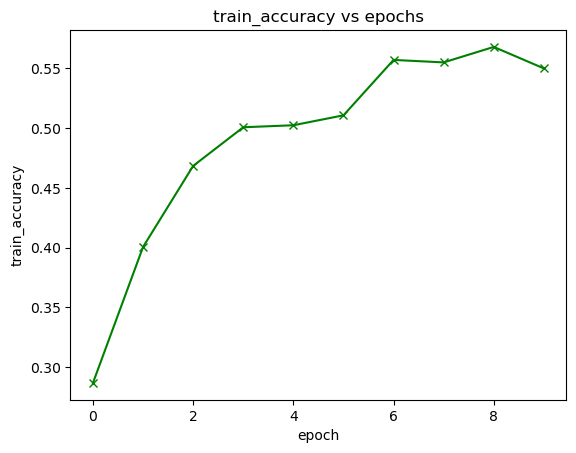

In [11]:
accuracies = [x["test_acc"] for x in history]

plt.xlabel("epoch")
plt.ylabel("train_accuracy")
plt.title("train_accuracy vs epochs")
plt.plot(accuracies, "-gx")

Next we have the losses both on test and training data.

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

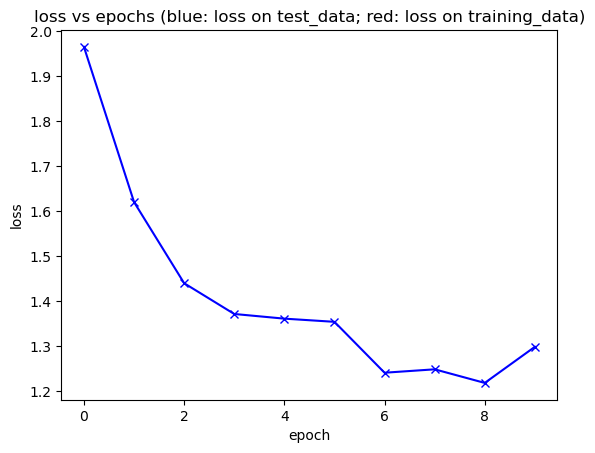

In [12]:
test_loss = [x["test_loss"] for x in history]
loss = [x["loss"] for x in history]

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss vs epochs (blue: loss on test_data; red: loss on training_data)")
plt.plot(test_loss, "-bx")
plt.plot(loss, "-rx")

In [13]:
def predict(input):
    out = model(input.reshape(1, 3, 32, 32))
    _, pred = torch.max(out, dim=1)
    return classes[pred]

def check_sample(img_label_pair):
    imshow(img_label_pair[0])
    print("Predicted: " + predict(img_label_pair[0]))
    print("Desired output: " + classes[img_label_pair[1]])

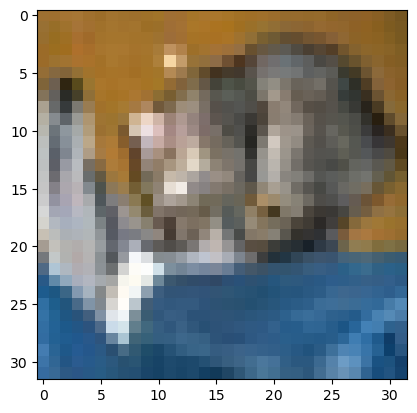

Predicted: cat
Desired output: cat


In [14]:
check_sample(test_ds[0])

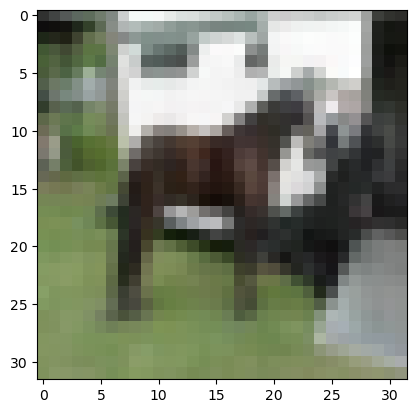

Predicted: horse
Desired output: horse


In [15]:
check_sample(test_ds[20])

In [ ]:
check_sample(test_ds[100])

In [ ]:
check_sample(test_ds[250])

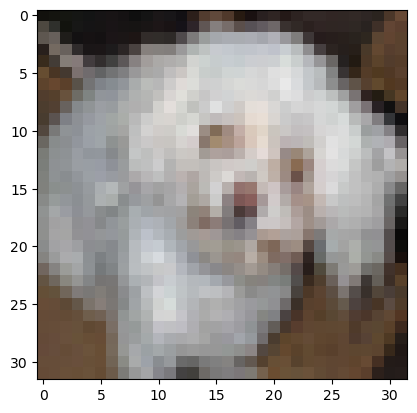

Predicted: dog
Desired output: dog


In [17]:
check_sample(test_ds[1000])

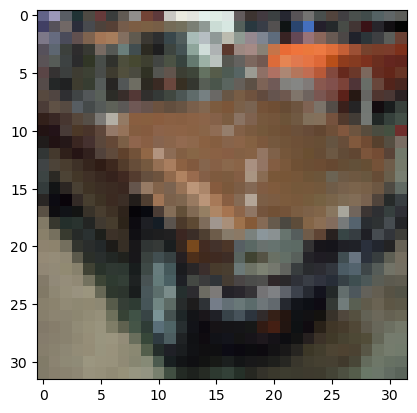

Predicted: frog
Desired output: car


In [16]:
check_sample(test_ds[2000])

In [19]:
torch.save(model.state_dict(), 'cifar10-model.pth')

In [20]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 3.7322e-02,  1.1034e-02,  5.0558e-02, -2.5233e-02, -2.3454e-02],
                        [ 2.2468e-02,  8.2310e-02,  7.2267e-02, -1.1250e-01, -3.7911e-02],
                        [-6.0561e-02, -8.2354e-02, -9.1839e-02,  3.4001e-02, -8.4258e-02],
                        [-7.7887e-03, -7.2076e-03, -7.5926e-02, -1.2122e-01,  8.8016e-02],
                        [ 4.3505e-02,  7.2914e-02,  8.3658e-02, -2.7573e-03, -4.9245e-02]],
              
                       [[ 1.0617e-01,  1.0091e-01, -1.5921e-02,  3.5982e-02, -1.2541e-01],
                        [ 6.7071e-02, -3.7687e-02, -8.0909e-03,  4.7380e-02, -1.2938e-01],
                        [ 7.1008e-02, -9.9227e-02,  6.0967e-02,  1.0152e-01, -8.1277e-02],
                        [ 3.8813e-02, -8.1193e-02, -3.3186e-03, -4.0353e-02,  8.0762e-02],
                        [-8.3481e-02, -3.2978e-02, -1.0776e-01,  2.4476e-02, -2.3875e-02]],
              
                       [[ 4.

In [21]:
model2 = CifarModel()
model2.load_state_dict(torch.load('cifar10-model.pth'))
model2.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 3.7322e-02,  1.1034e-02,  5.0558e-02, -2.5233e-02, -2.3454e-02],
                        [ 2.2468e-02,  8.2310e-02,  7.2267e-02, -1.1250e-01, -3.7911e-02],
                        [-6.0561e-02, -8.2354e-02, -9.1839e-02,  3.4001e-02, -8.4258e-02],
                        [-7.7887e-03, -7.2076e-03, -7.5926e-02, -1.2122e-01,  8.8016e-02],
                        [ 4.3505e-02,  7.2914e-02,  8.3658e-02, -2.7573e-03, -4.9245e-02]],
              
                       [[ 1.0617e-01,  1.0091e-01, -1.5921e-02,  3.5982e-02, -1.2541e-01],
                        [ 6.7071e-02, -3.7687e-02, -8.0909e-03,  4.7380e-02, -1.2938e-01],
                        [ 7.1008e-02, -9.9227e-02,  6.0967e-02,  1.0152e-01, -8.1277e-02],
                        [ 3.8813e-02, -8.1193e-02, -3.3186e-03, -4.0353e-02,  8.0762e-02],
                        [-8.3481e-02, -3.2978e-02, -1.0776e-01,  2.4476e-02, -2.3875e-02]],
              
                       [[ 4.

In [22]:
print("Accuracy:" + str(model_accuracy(test_loader, model2)))
print("Loss: " + str(model_loss(test_loader, model2)))

Accuracy:0.549940664556962
Loss: 1.2982119125655935
